## Hospital Dataset Classification


### Import Libraries

In [144]:
import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.compose import make_column_transformer
from sklearn.datasets import make_classification
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from tabulate import tabulate

### Dataset Exploration

In [145]:
# Import Dataset

data_train = pd.read_csv("./datasets/classification_Healthcare-Dataset.csv")
data_test = pd.read_csv("./datasets/classification_Unknown-Dataset.csv")

In [146]:
# Show Dataset Sample

pd.concat([data_train.head(), data_train.tail()])

,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,ethnicity,...,NumMicroLabs,NumNotes,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum
0,F,35.0,6,1,CLINIC REFERRAL/PREMATURE,DIABETIC KETOACIDOSIS,3,PROTESTANT QUAKER,DIVORCED,WHITE,...,4,0,5,15,7,4,399,0,494,NaN
1,M,59.0,4,1,EMERGENCY ROOM ADMIT,UPPER GI BLEED,3,NOT SPECIFIED,SINGLE,WHITE,...,5,6,5,7,4,5,373,0,466,NaN
2,F,73.0,7,1,EMERGENCY ROOM ADMIT,BOWEL OBSTRUCTION,3,JEWISH,MARRIED,WHITE,...,5,1,9,12,0,7,526,0,603,NaN
3,M,60.0,5,1,TRANSFER FROM HOSP/EXTRAM,CORONARY ARTERY DISEASE,3,CATHOLIC,MARRIED,WHITE,...,3,2,16,25,14,10,555,0,680,NaN
4,F,54.0,4,0,PHYS REFERRAL/NORMAL DELI,RENAL MASS LEFT/SDA,3,EPISCOPALIAN,MARRIED,WHITE,...,0,0,8,9,5,4,449,0,509,NaN
47175,M,74.0,36,0,PHYS REFERRAL/NORMAL DELI,RECTAL CANCER/SDA,2,ROMANIAN EAST. ORTH,MARRIED,WHITE,...,30,1,2,3,0,6,57,0,89,NaN
47176,F,85.0,3,1,TRANSFER FROM HOSP/EXTRAM,BRADYCARDIA,2,JEWISH,SINGLE,WHITE,...,8,1,5,14,3,4,358,0,447,1.0
47177,M,60.0,25,1,TRANSFER FROM HOSP/EXTRAM,CORONARY ARTERY DISEASE,3,CATHOLIC,DIVORCED,UNKNOWN/NOT SPECIFIED,...,5,3,23,8,0,2,1315,0,1746,NaN
47178,M,23.0,17,1,PHYS REFERRAL/NORMAL DELI,ROOT ABSCESS,3,PROTESTANT QUAKER,SINGLE,WHITE,...,9,2,6,6,0,6,207,0,261,4.0
47179,M,88.0,6,1,CLINIC REFERRAL/PREMATURE,PNEUMONIA,2,JEWISH,MARRIED,WHITE,...,10,2,5,6,3,4,550,0,615,NaN


In [147]:
# Create List with either numerical columns or categorical columns

train_columns=list(data_train.columns)

attribute_descriptions = {} 
list_numerical=[]
list_categorical=[]
unique_categories_printed = set()  

for i in range(len(train_columns)):
    column_name = train_columns[i]
    description = data_train[train_columns[i]].describe()
    attribute_descriptions[column_name] = description 
    column_name = train_columns[i]

    if attribute_descriptions[column_name].dtype == object:
        if column_name not in unique_categories_printed:
            list_categorical.append(column_name)
            unique_categories_printed.add(column_name)
    else:
        if column_name not in unique_categories_printed:
            list_numerical.append(column_name)
           
print(f"Numerical Columns: {list_numerical}")
print(f"Categorical Columns: {list_categorical}")

Numerical Columns: ['age', 'LOSdays', 'admit_type', 'insurance', 'NumCallouts', 'NumDiagnosis', 'NumProcs', 'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes', 'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers', 'NumChartEvents', 'ExpiredHospital', 'TotalNumInteract', 'LOSgroupNum']
Categorical Columns: ['gender', 'admit_location', 'AdmitDiagnosis', 'religion', 'marital_status', 'ethnicity', 'AdmitProcedure']


In [148]:
# Calculate Percentage of missing values

missing_values = data_train.isna()
sum_missing_values=missing_values.sum()
total_values=data_train.shape[0]
percentage=(sum_missing_values/total_values)*100
missing_values= percentage[percentage>0]
missing_values_table=pd.DataFrame(missing_values,columns=['Percentage Missing'])
missing_values_table

,Percentage Missing
age,4.957609
AdmitDiagnosis,0.042391
religion,0.788470
marital_status,17.335735
NumCallouts,5.023315
LOSgroupNum,89.968207


gender


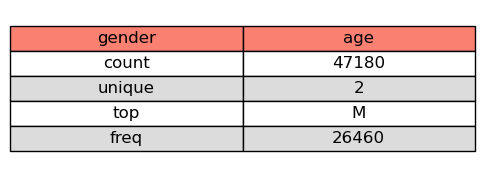

age


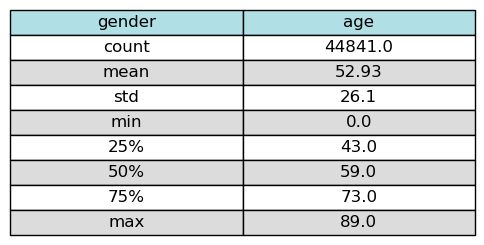

In [149]:
# Create attribute description tables 

attribute_descriptions = {} 

for column in train_columns[:2]: # only the first two for demo purposes
    description = data_train[column].describe()
    attribute_descriptions[column] = description

    value = attribute_descriptions[column].tolist()
    
    index = attribute_descriptions[column].index.tolist() 
    rounded_values = []
    for val in value:
        if isinstance(val, (int, float)):  # Check if the value is numeric
            rounded_values.append(round(val, 2))
        else:
            rounded_values.append(val)  
    data_for_descriptions = {
        'Statistics': index,
        'Values': rounded_values
    }
    df = pd.DataFrame(data_for_descriptions)
    
    fig, ax = plt.subplots(figsize=(6, 4)) 
    plt.subplots_adjust(top=0.5) 
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=train_columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5) 

    #set color of first row according to attribute type
    for i, key in enumerate(df.keys()):
        if attribute_descriptions[column].dtype==object:
            cell = table.get_celld()[0, i]  
            cell.set_facecolor('salmon')  
            
        else:
            cell = table.get_celld()[0, i]  
            cell.set_facecolor('powderblue')  

           
    #grey color of rows
    for row in range(2, len(df)+1, 2):
        for i, key in enumerate(df.keys()):
            cell = table.get_celld()[row, i]
            cell.set_facecolor('gainsboro')
            
    print(column)
    plt.show()
    plt.close()

age


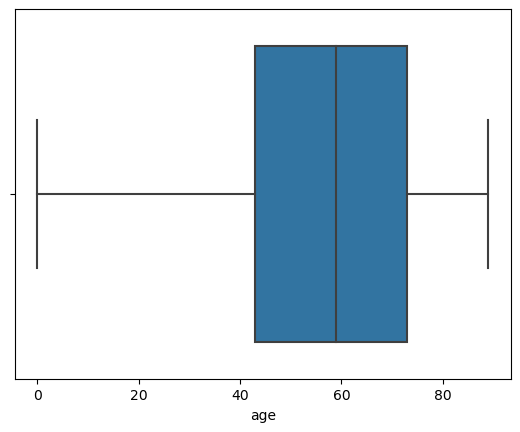

In [150]:
# Create Boxplot Visualizations

list_for_boxplot= ['age', 'LOSdays', 'NumDiagnosis', 'NumProcs', 'NumCPTevents', 'NumInput', 'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers', 'NumChartEvents', 'TotalNumInteract']

for column_name in list_for_boxplot[:1]: # only first one for demo purposes
    print(column_name)
    dataforboxplot=data_train[column_name]
    sns.boxplot(x=dataforboxplot)
    plt.show()

### Preprocessing

In [151]:
# Drop columns that are irrelevant or contain too much noise

columns_to_drop=["LOSgroupNum","NumCallouts","LOSgroupNum","NumNotes","NumLabs","NumMicroLabs",'gender',
 'AdmitDiagnosis',
 'religion',
 'marital_status',
 'ethnicity',
 'AdmitProcedure',
 'insurance']

data_train=data_train.drop(columns=columns_to_drop)
data_train.head()

,age,LOSdays,admit_type,admit_location,NumDiagnosis,NumProcs,NumCPTevents,NumInput,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract
0,35.0,6,1,CLINIC REFERRAL/PREMATURE,16,0,8,25,5,15,7,4,399,0,494
1,59.0,4,1,EMERGENCY ROOM ADMIT,9,4,8,14,5,7,4,5,373,0,466
2,73.0,7,1,EMERGENCY ROOM ADMIT,5,2,5,20,9,12,0,7,526,0,603
3,60.0,5,1,TRANSFER FROM HOSP/EXTRAM,18,4,11,20,16,25,14,10,555,0,680
4,54.0,4,0,PHYS REFERRAL/NORMAL DELI,5,3,7,7,8,9,5,4,449,0,509


In [152]:
# Impute Missing Values

numerical_columns = data_train.select_dtypes(exclude=['object']).columns # Get current numerical columns
numerical_imputer = SimpleImputer(strategy='mean') 
data_train[numerical_columns] = numerical_imputer.fit_transform(data_train[numerical_columns]) 


In [153]:
# Remove Duplicates 

shapebefore=data_train.shape
data_train = data_train.drop_duplicates(keep='first')
shapeafter=data_train.shape
data_train = data_train.reset_index(drop=True)
number_of_duplicates_removed=shapebefore[0]-shapeafter[0]
number_of_duplicates_removed

255

In [ ]:
# Remove Outliers

def remove_outliers_iqr(df, threshold=12):
    cleaned_df = df.copy()
    
    columns_to_exclude = ['ExpiredHospital', "admit_type"]    

    for column in df.columns:
        if column not in columns_to_exclude and pd.api.types.is_numeric_dtype(df[column]):
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR

            is_outlier = ((df[column] < lower_bound) | (df[column] > upper_bound))
            removed_columns = ((df[column] > lower_bound) | (df[column] < upper_bound))
            
            cleaned_df = cleaned_df[~is_outlier]

    return cleaned_df, removed_columns

data_train, removed_columns = remove_outliers_iqr(data_train);



In [155]:
# Encode Data of "admit_location" column

onehot = OneHotEncoder(dtype=int, sparse_output=False)
encoded_data = onehot.fit_transform(data_train[["admit_location"]])
column_names = onehot.get_feature_names_out(["admit_location"])
column_names = [name.split('_')[2] for name in column_names]
admit_location_encoded_dataframe = pd.DataFrame(encoded_data, columns=column_names)
admit_location_encoded_dataframe.sample(5)


,** INFO NOT AVAILABLE **,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,HMO REFERRAL/SICK,PHYS REFERRAL/NORMAL DELI,TRANSFER FROM HOSP/EXTRAM,TRANSFER FROM OTHER HEALT,TRANSFER FROM SKILLED NUR,TRSF WITHIN THIS FACILITY
18847,0,0,1,0,0,0,0,0,0
25499,0,1,0,0,0,0,0,0,0
3678,0,0,0,0,1,0,0,0,0
2253,0,0,0,0,1,0,0,0,0
44274,0,0,1,0,0,0,0,0,0


In [156]:
# Encode Data of "admit_type" column

onehot = OneHotEncoder(dtype=int, sparse_output=False)
encoded_data = onehot.fit_transform(data_train[["admit_type"]])
column_names = onehot.get_feature_names_out(["admit_type"])
admit_type_encoded_dataframe = pd.DataFrame(encoded_data, columns=column_names)
admit_type_encoded_dataframe.sample(5)

,admit_type_0.0,admit_type_1.0,admit_type_2.0,admit_type_3.0
17375,0,1,0,0
33121,0,1,0,0
8020,0,0,1,0
10221,0,1,0,0
35808,0,1,0,0


In [157]:
# Select features for training

data_train = data_train.reset_index(drop=True)
data = pd.concat([data_train,admit_type_encoded_dataframe],axis=1) 
X = data.drop(columns=["admit_location","admit_type","ExpiredHospital"])
y = data_train["ExpiredHospital"]

In [158]:
# Normalize Data

columns_normalisation=['age', 'LOSdays', 'NumDiagnosis', 'NumProcs', 'NumCPTevents',
       'NumInput', 'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers',
       'NumChartEvents', 'TotalNumInteract']
StdScaler = StandardScaler()
X_normalised=X
X_normalised[columns_normalisation] = StdScaler.fit_transform(X[columns_normalisation])

In [159]:
# Balance the dataset 

undersampler = RandomUnderSampler(sampling_strategy=0.35,random_state=24) #Random Undersampling
X_under, y_under = undersampler.fit_resample(X, y)
X_normalised_under, y_under = undersampler.fit_resample(X_normalised, y)

### Classification

In [160]:
# Define confusion matrix plotting function

def plot_confusion_matrix(y_test,y_pred,plot_title):
    fig,ax = plt.subplots(figsize=(5,4),dpi = 100)
    plt.title(str(plot_title))
    cm = confusion_matrix(y_test, y_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels = ["not expired","expired"])
    cmp.plot(ax = ax)

In [161]:
# Define ROC / AUC plotting function

def plot_roc_auc(y_test,y_probs_class_1,plot_title):
    auc = roc_auc_score(y_test, y_probs_class_1)
    print('The AUC is {:.3f}'.format(auc)) 

    fpr, tpr, thresholds = roc_curve(y_test, y_probs_class_1, pos_label=1)

    plt.figure()
    lw = 2 
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC "+str(plot_title))
    plt.legend(loc="lower right")
    plt.show()

#### Decision Tree

In [162]:
#split the dataset

X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(X_under, y_under, test_size=0.2, random_state=1234)

In [163]:
# train DT classifier
clf_DT = DecisionTreeClassifier(max_depth=5,max_leaf_nodes=3,random_state=1234) 
clf_DT.fit(X_train_DT, y_train_DT)

# Get predictions
y_pred_DT = clf_DT.predict(X_test_DT)

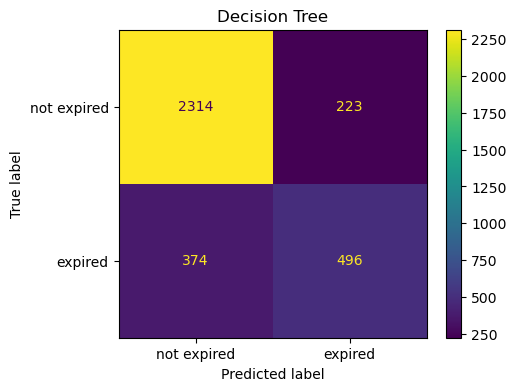

In [164]:
# confusion matrix

plot_confusion_matrix(y_test_DT, y_pred_DT, "Decision Tree")


In [165]:
# classification report

report_DT = metrics.classification_report(y_test_DT, y_pred_DT)
print(report_DT)

              precision    recall  f1-score   support

         0.0       0.86      0.91      0.89      2537
         1.0       0.69      0.57      0.62       870

    accuracy                           0.82      3407
   macro avg       0.78      0.74      0.76      3407
weighted avg       0.82      0.82      0.82      3407



The AUC is 0.750


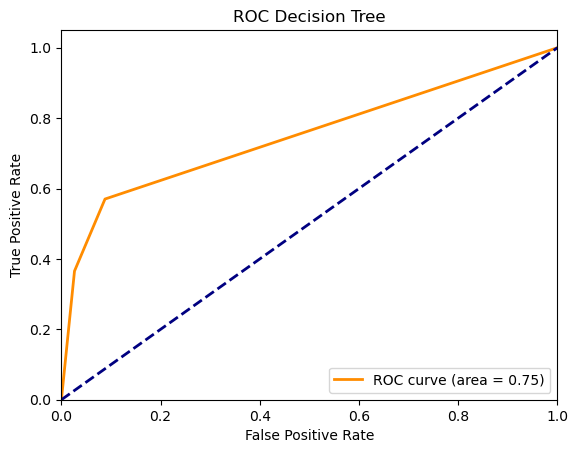

In [166]:
# ROC and AUC

y_probs = clf_DT.predict_proba(X_test_DT)
y_probs_class_1 = y_probs[:,1]
plot_roc_auc(y_test_DT,y_probs_class_1,"Decision Tree")

#### KNN Classifier

In [167]:
#split the dataset

X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN = train_test_split(X_under, y_under, test_size=0.2,random_state=1234) 

In [168]:
#train KNN classifier

clf_KNN = KNeighborsClassifier(n_neighbors = 3)
clf_KNN.fit(X_train_KNN, y_train_KNN)
optimal_threshold = 0.36

In [169]:
# Get predicted probabilities
y_probabilities = clf_KNN.predict_proba(X_test_KNN.values)[:, 1]

# Set the optimal threshold 
optimal_threshold = 0.35

# Get predictions
y_pred_KNN = (y_probabilities >= optimal_threshold).astype(int)

c:\Users\janni\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


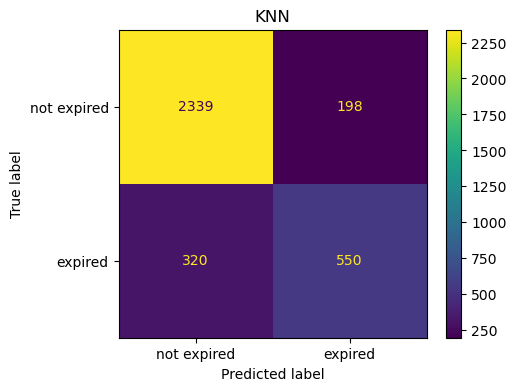

In [170]:
# confusion matrix

plot_confusion_matrix(y_test_KNN, y_pred_KNN,"KNN")

In [171]:
# classification report

report_KNN = metrics.classification_report(y_test_KNN, y_pred_KNN)
print(report_KNN)

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90      2537
         1.0       0.74      0.63      0.68       870

    accuracy                           0.85      3407
   macro avg       0.81      0.78      0.79      3407
weighted avg       0.84      0.85      0.84      3407



The AUC is 0.850


c:\Users\janni\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


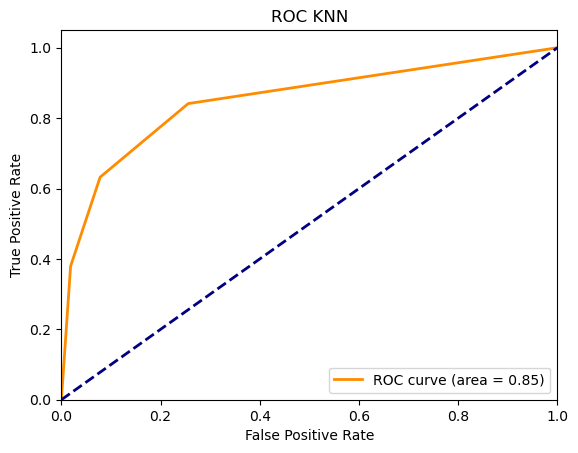

In [172]:
# ROC and AUC

y_probs = clf_KNN.predict_proba(X_test_KNN.values)
y_probs_class_1 = y_probs[:,1]
plot_roc_auc(y_test_KNN, y_probs_class_1,"KNN")

#### Random Forest

In [173]:
# split the dataset

X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X_under, y_under, test_size=0.2,random_state=1234)

In [174]:
# train RF classifier

clf_RF = RandomForestClassifier(random_state=1234)
clf_RF.fit(X_train_RF, y_train_RF)

RandomForestClassifier(random_state=1234)

In [175]:
# Get predicted probabilities
y_probabilities = clf_RF.predict_proba(X_test_RF)[:, 1]

# Set the optimal threshold 
optimal_threshold = 0.35

# Get predictions
y_pred_RF = (y_probabilities >= optimal_threshold).astype(int)


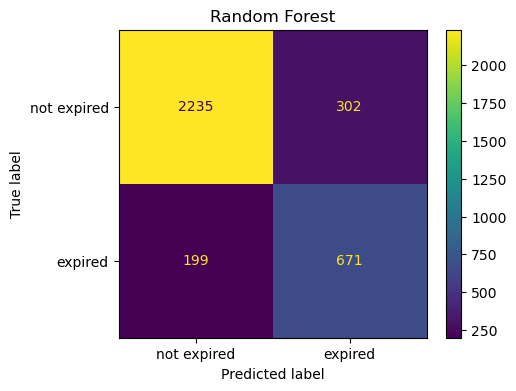

In [176]:
plot_confusion_matrix(y_test_RF, y_pred_RF,"Random Forest")

In [177]:
#classification report

report_RF = metrics.classification_report(y_test_RF, y_pred_RF)
print(report_RF)

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90      2537
         1.0       0.69      0.77      0.73       870

    accuracy                           0.85      3407
   macro avg       0.80      0.83      0.81      3407
weighted avg       0.86      0.85      0.86      3407



The AUC is 0.913


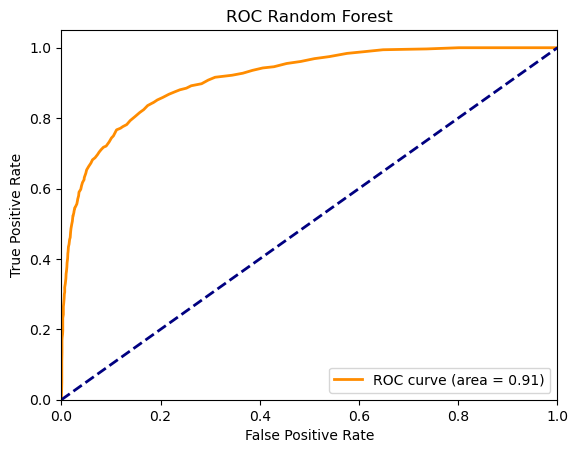

In [178]:
#ROC and AUC

y_probs = clf_RF.predict_proba(X_test_RF)
y_probs_class_1 = y_probs[:,1]
plot_roc_auc(y_test_RF, y_probs_class_1, "Random Forest")

#### AdaBoostClassifier

In [179]:
# split the dataset

X_train_AB, X_test_AB, y_train_AB, y_test_AB = train_test_split(X_under, y_under, test_size=0.2,random_state=1234)

In [180]:
# train AB classifier

clf_AB = AdaBoostClassifier(n_estimators=50,random_state=1234)
clf_AB.fit(X_train_AB, y_train_AB)

c:\Users\janni\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(random_state=1234)

In [181]:
# Get predicted probabilities
y_probabilities = clf_AB.predict_proba(X_test_AB)[:, 1]

# Set the optimal threshold 
optimal_threshold = 0.4966

# Get predictions
y_pred_AB = (y_probabilities >= optimal_threshold).astype(int)


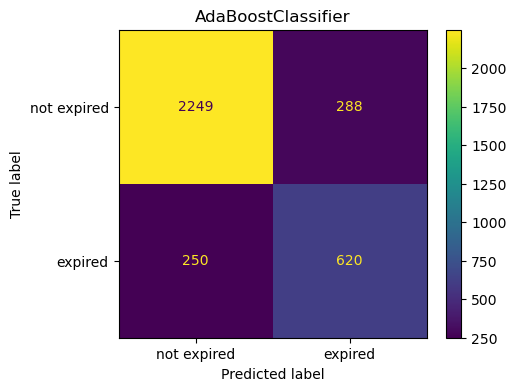

In [182]:
# confusion matrix

plot_confusion_matrix(y_test_AB, y_pred_AB,"AdaBoostClassifier")

In [183]:
# classification report

report_AB = metrics.classification_report(y_test_AB, y_pred_AB)
print(report_AB)


              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89      2537
         1.0       0.68      0.71      0.70       870

    accuracy                           0.84      3407
   macro avg       0.79      0.80      0.80      3407
weighted avg       0.84      0.84      0.84      3407



The AUC is 0.897


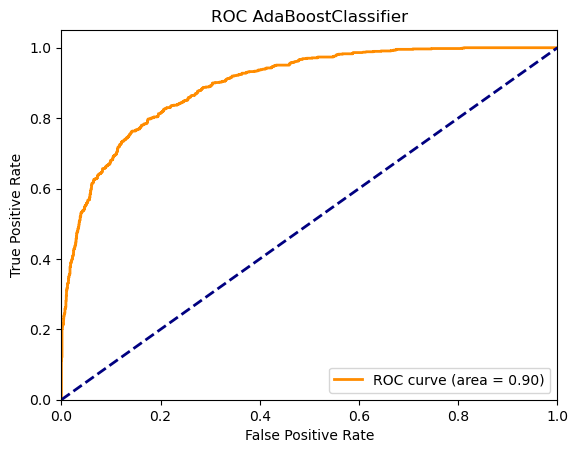

In [184]:
# ROC and AUC
y_probs = clf_AB.predict_proba(X_test_AB)
y_probs_class_1 = y_probs[:,1]

plot_roc_auc(y_test_AB, y_probs_class_1,"AdaBoostClassifier")

#### BalancedRandomForestClassifier

In [185]:
# split the dataset

X_train_BRF, X_test_BRF, y_train_BRF, y_test_BRF = train_test_split(X_under, y_under, test_size=0.2, random_state=1234)

In [186]:
# train brf classifier

clf_BRF = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
clf_BRF.fit(X_train_BRF, y_train_BRF)

c:\Users\janni\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\janni\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\janni\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


BalancedRandomForestClassifier(random_state=0)

In [187]:
# Get predicted probabilities
y_probabilities = clf_BRF.predict_proba(X_test_BRF)[:, 1]

# Set the optimal threshold 
optimal_threshold = 0.6

# Get Predictions
y_pred_BRF = (y_probabilities >= optimal_threshold).astype(int)


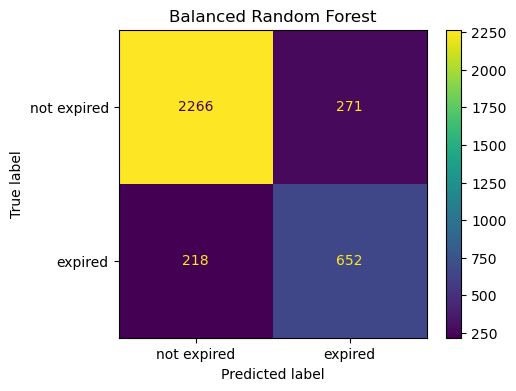

In [188]:
# confusion matrix

plot_confusion_matrix(y_test_BRF, y_pred_BRF,"Balanced Random Forest")


In [189]:
# classification report

report_BRF = metrics.classification_report(y_test_BRF, y_pred_BRF)
print(report_BRF)

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90      2537
         1.0       0.71      0.75      0.73       870

    accuracy                           0.86      3407
   macro avg       0.81      0.82      0.81      3407
weighted avg       0.86      0.86      0.86      3407



The AUC is 0.914


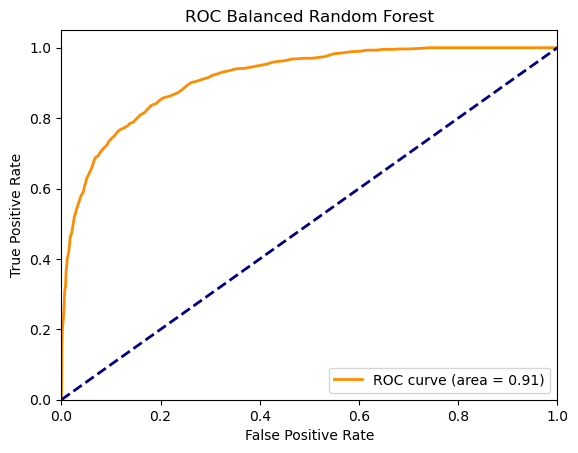

In [190]:
# ROC and AUC

y_probs = clf_BRF.predict_proba(X_test_BRF)
y_probs_class_1 = y_probs[:,1]

plot_roc_auc(y_test_BRF, y_probs_class_1,"Balanced Random Forest")


#### Gradient Boosting Classifier

In [191]:
# split the dataset

X_train_GB, X_test_GB, y_train_GB, y_test_GB = train_test_split(X_under, y_under, test_size=0.2, random_state=1234)

In [192]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.1],
    'max_depth': [4],
}

# Create the GridSearchCV object with early stopping
clf_GB = GridSearchCV(
    GradientBoostingClassifier(random_state=123, n_iter_no_change=5, validation_fraction=0.1),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=1
    )

# Get the best parameters
clf_GB.fit(X_train_GB, y_train_GB)
best_params = clf_GB.best_params_
print("Best Parameters:", best_params)

# Get the best estimator
best_estimator = clf_GB.best_estimator_

# Train the final model on the full dataset
best_estimator.fit(X_train_GB, y_train_GB)

# Evaluate the model on the test data
y_pred = best_estimator.predict(X_test_GB.values)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}


c:\Users\janni\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [193]:
# Get predicted probabilities
y_probabilities = best_estimator.predict_proba(X_test_GB)[:, 1]

# Set the optimal threshold 
optimal_threshold = 0.3

# Get predictions
y_pred_GB = (y_probabilities >= optimal_threshold).astype(int)


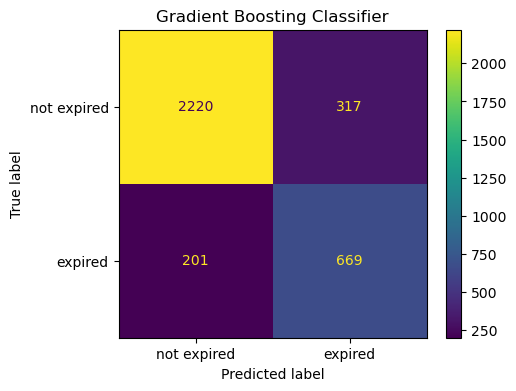

In [194]:
# confusion matrix
plot_confusion_matrix(y_test_GB, y_pred_GB,"Gradient Boosting Classifier")

In [195]:
# classification report

report_GB = metrics.classification_report(y_test_GB, y_pred_GB)
print(report_GB)

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90      2537
         1.0       0.68      0.77      0.72       870

    accuracy                           0.85      3407
   macro avg       0.80      0.82      0.81      3407
weighted avg       0.86      0.85      0.85      3407



The AUC is 0.913


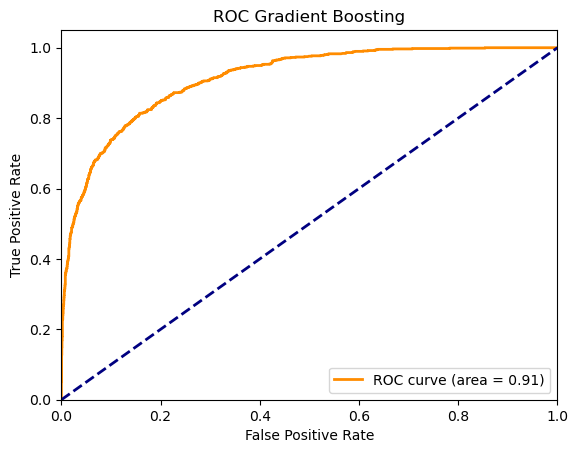

In [196]:
#ROC and AUC

y_probs = clf_GB.predict_proba(X_test_GB)
y_probs_class_1 = y_probs[:,1]
plot_roc_auc(y_test_GB, y_probs_class_1,"Gradient Boosting")


#### Support Vector Machine

In [197]:
# split the dataset

X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(X_normalised_under, y_under, test_size=0.2,random_state=1234)

In [198]:
# train SVM classifier

clf_SVM = SVC(
    kernel='rbf',       
    gamma='scale',         
    probability=True,      
    random_state=1234
)

clf_SVM.fit(X_train_SVM, y_train_SVM)

SVC(probability=True, random_state=1234)

In [199]:
# Get predicted probabilities
y_probabilities = clf_SVM.predict_proba(X_test_SVM)[:, 1]

# Set the optimal threshold 
optimal_threshold = 0.21
y_probabilities

# Get predictions
y_pred_SVM = (y_probabilities >= optimal_threshold).astype(int)


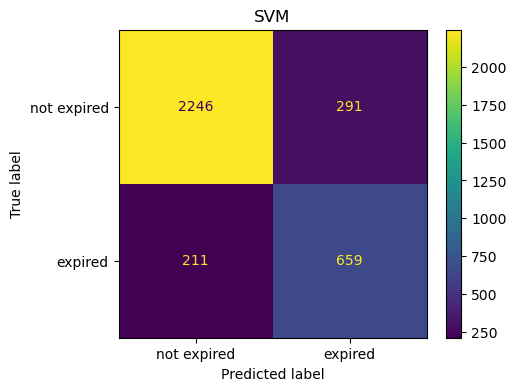

In [200]:
# confusion matrix

plot_confusion_matrix(y_test_SVM, y_pred_SVM,"SVM")

In [201]:
# classification report

report_SVM = metrics.classification_report(y_test_SVM, y_pred_SVM)
print(report_SVM)

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90      2537
         1.0       0.69      0.76      0.72       870

    accuracy                           0.85      3407
   macro avg       0.80      0.82      0.81      3407
weighted avg       0.86      0.85      0.85      3407



The AUC is 0.905


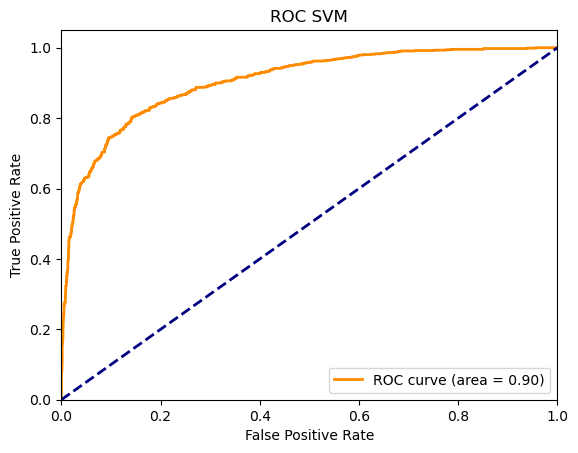

In [202]:
# ROC and AUC

y_probs = clf_SVM.predict_proba(X_test_SVM)
y_probs_class_1 = y_probs[:,1]
plot_roc_auc(y_test_SVM, y_probs_class_1,"SVM")


#### Neural Network

In [203]:
# split the dataset

X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X_normalised_under, y_under, test_size=0.2, random_state=1234)

In [204]:
# train NN classifier

clf_NN = MLPClassifier(
    hidden_layer_sizes=(64, 32,16,8),   
    activation='relu',             
    alpha=0.0001,                  
    solver='adam',             
    learning_rate_init=0.001,    
    max_iter=1000,                
    early_stopping=True,           
    validation_fraction=0.2,                       
    random_state=1234
)
clf_NN.fit(X_train_NN, y_train_NN)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(64, 32, 16, 8),
              max_iter=1000, random_state=1234, validation_fraction=0.2)

In [205]:
# Get predicted probabilities
y_probabilities = clf_NN.predict_proba(X_test_NN)[:, 1]

# Set the optimal threshold 
optimal_threshold = 0.25

# Get Predictions
y_pred_NN = (y_probabilities >= optimal_threshold).astype(int)


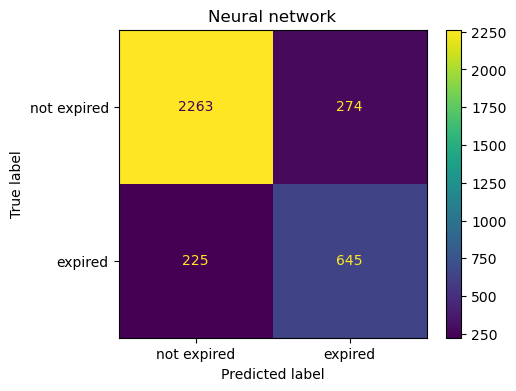

In [206]:
# confusion matrix

plot_confusion_matrix(y_test_NN, y_pred_NN,"Neural network")

In [207]:
# classification report

report_NN = metrics.classification_report(y_test_NN, y_pred_NN)
print(report_NN)

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90      2537
         1.0       0.70      0.74      0.72       870

    accuracy                           0.85      3407
   macro avg       0.81      0.82      0.81      3407
weighted avg       0.86      0.85      0.85      3407



The AUC is 0.911


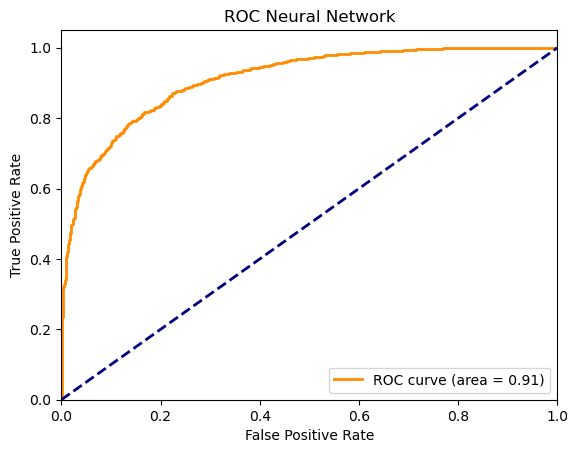

In [208]:
# ROC and AUC

y_probs = clf_NN.predict_proba(X_test_NN)
y_probs_class_1 = y_probs[:,1]
plot_roc_auc(y_test_NN, y_probs_class_1,"Neural Network")

#### Logistic Regression 

In [209]:
# split the dataset

X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(X_normalised_under, y_under, test_size=0.25, random_state=1234)

In [210]:
# train LogisticRegression classifier

clf_LR = LogisticRegression(
    max_iter=1000,  
    random_state=1234  
)
clf_LR.fit(X_train_LR, y_train_LR)

LogisticRegression(max_iter=1000, random_state=1234)

In [211]:
# Get predicted probabilities
y_probabilities = clf_LR.predict_proba(X_test_LR)[:, 1]

# Set the optimal threshold 
optimal_threshold = 0.3

# Get predictions
y_pred_LR = (y_probabilities >= optimal_threshold).astype(int)


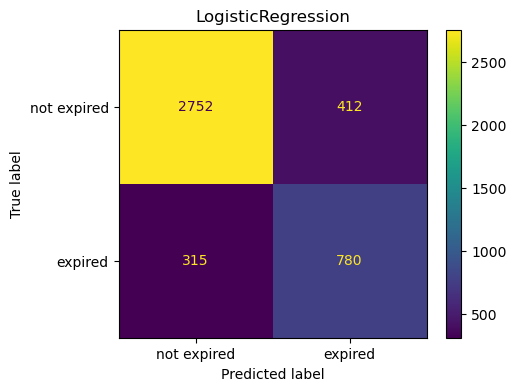

In [212]:
# confusion matrix

plot_confusion_matrix(y_test_LR, y_pred_LR,"LogisticRegression")

In [213]:
# classification report

report_LR = metrics.classification_report(y_test_LR, y_pred_LR)
print(report_LR)

              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88      3164
         1.0       0.65      0.71      0.68      1095

    accuracy                           0.83      4259
   macro avg       0.78      0.79      0.78      4259
weighted avg       0.83      0.83      0.83      4259



The AUC is 0.870


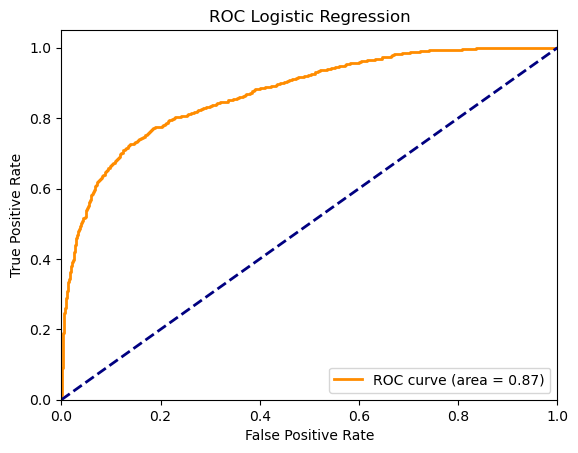

In [214]:
# ROC and AUC

y_probs = clf_LR.predict_proba(X_test_LR)
y_probs_class_1 = y_probs[:,1]
plot_roc_auc(y_test_LR, y_probs_class_1,"Logistic Regression")

#### Preprocess Kaggle test data

In [215]:
data_test=data_test.drop(columns=columns_to_drop)

In [216]:
# Impute numerical columns

numerical_columns = data_test.select_dtypes(exclude=['object']).columns
data_test[numerical_columns] = numerical_imputer.fit_transform(data_test[numerical_columns])

In [217]:
# admit_location data encoding

onehot = OneHotEncoder(dtype=int, sparse_output=False)
encoded_data = onehot.fit_transform(data_test[["admit_location"]])
column_names = onehot.get_feature_names_out(["admit_location"])
column_names = [name.split('_')[2] for name in column_names]
admit_location_encoded_dataframe = pd.DataFrame(encoded_data, columns=column_names)

In [218]:
#admit_type data encoding

onehot = OneHotEncoder(dtype=int, sparse_output=False)
encoded_data = onehot.fit_transform(data_test[["admit_type"]])
column_names = onehot.get_feature_names_out(["admit_type"])
admit_type_encoded_dataframe = pd.DataFrame(encoded_data, columns=column_names)

In [219]:
# test data feature selection

data_test_features= pd.concat([data_test,admit_type_encoded_dataframe], axis=1)  
X_test=data_test_features.drop(columns=["admit_location","admit_type"])

In [220]:
# StandardScaler transformation of test data

X_normalised_test=X_test
X_normalised_test[columns_normalisation] = StdScaler.fit_transform(X_normalised_test[columns_normalisation])

In [221]:
# create DataFrame for kaggle submission

def create_row_dataframe(num_rows=11795):
    row_names = [f'Row{i}' for i in range(0, num_rows + 1)]
    row_df = pd.DataFrame(row_names, columns=['row ID'])
    return row_df

row_dataframe = create_row_dataframe()

### Classify unknown dataset

In [222]:
def save_results(y_pred_test,filename):
    predictions = pd.DataFrame(y_pred_test, index=row_dataframe['row ID'], columns=["Predicted-ExpiredHospital"])
    predictions.to_csv(f"./predictions/{filename}.csv")

In [223]:
# Decision Tree

y_pred_DT_test = clf_DT.predict(X_test)
save_results(y_pred_DT_test,"predictions_DT")


In [224]:
 # KNN

y_pred_KNN_test = clf_KNN.predict(X_test)
save_results(y_pred_KNN_test,"predictions_KNN")

In [225]:
# Random Forest

y_pred_RF_test = clf_RF.predict(X_test)
save_results(y_pred_RF_test,"predictions_RF")

In [226]:
# Balanced Random Forest

y_pred_BRF_test = clf_BRF.predict(X_test)
save_results(y_pred_BRF_test,"predictions_BRF")


In [227]:
# Adaboost Classifier

y_pred_AB_test = clf_AB.predict(X_test)
save_results(y_pred_AB_test,"predictions_AB")


In [228]:
# Gradient Boost

y_pred_GB_test = clf_GB.predict(X_test)
save_results(y_pred_GB_test,"predictions_GB")


In [229]:
# SVM

y_pred_SVM_test = clf_SVM.predict(X_normalised_test)
save_results(y_pred_SVM_test,"predictions_SVM")


In [230]:
# Neural Network 

y_pred_NN_test = clf_NN.predict(X_normalised_test)
save_results(y_pred_NN_test,"predictions_NN")


In [231]:
# Logistic Regression

y_pred_LR_test = clf_LR.predict(X_normalised_test)
save_results(y_pred_LR_test,"predictions_LR")


### Metrics Comparison

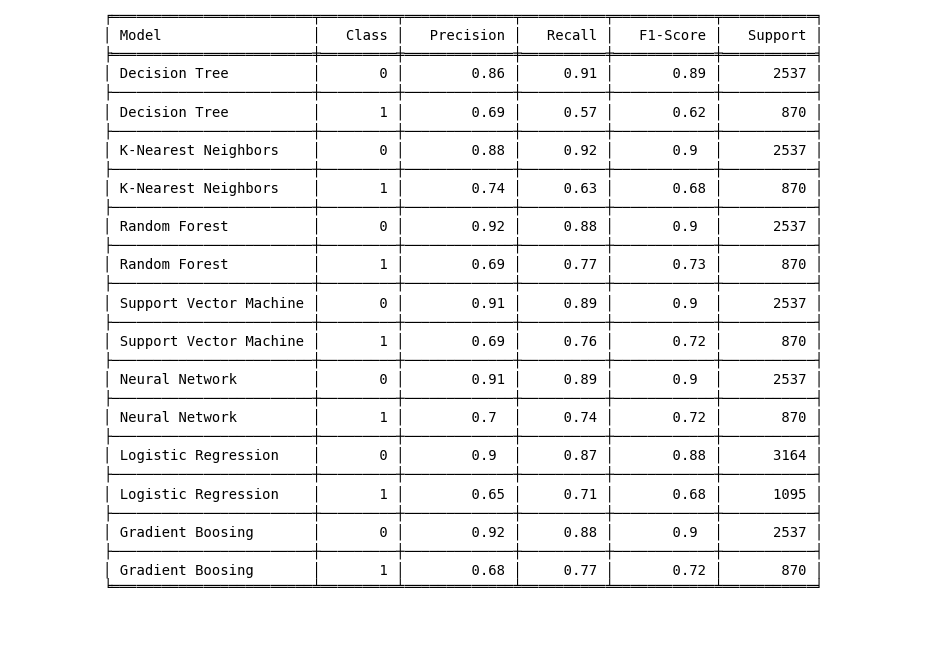

In [232]:
# recall, precision & F1 score

reports = [report_DT, report_KNN, report_RF, report_SVM, report_NN,report_LR,report_GB]

model_names = ['Decision Tree', 'K-Nearest Neighbors', 'Random Forest', 'Support Vector Machine', 'Neural Network', "Logistic Regression","Gradient Boosing"]

table_data = []

for report, model_name in zip(reports, model_names):
    lines = report.split('\n')
    data = [line.split() for line in lines[2:4]]  
    for row in data:
        table_data.append([model_name] + row)

table = tabulate(table_data, headers=["Model", "Class", "Precision", "Recall", "F1-Score", "Support"], tablefmt="fancy_grid")

plt.figure(figsize=(12, 6))
plt.text(0.1, 0.1, table, fontsize=10, family='monospace')
plt.axis('off')
plt.show()

### Kaggle Challenge Results

In [233]:
model_names = ['Decision Tree', 'K-nearest neighbors', 'Random Forest', 'Support Vector Machine',"Neural Network","Logistic Regression", "Gradient Boosting"]

kaggle_score_accuracies= [0.70932, 0.76441, 0.80774, 0.80143, 0.79342, 0.762, 0.80053]  

# Create a pandas DataFrame
data = {
    'Kaggle Score': kaggle_score_accuracies
}

df = pd.DataFrame(data, index=model_names)

# Sort the DataFrame by Kaggle Score in descending order
sorted_df = df.sort_values(by='Kaggle Score', ascending=False)

sorted_df


,Kaggle Score
Random Forest,0.80774
Support Vector Machine,0.80143
Gradient Boosting,0.80053
Neural Network,0.79342
K-nearest neighbors,0.76441
Logistic Regression,0.76200
Decision Tree,0.70932
